# This Notebook aim to show you what I can do on a diversified portfolio.
# The optimization process is based on the returns.
# The system take into account various constraints.

In [518]:
# Library Importation : 
import pandas as pd
import numpy as np
import datetime
from datetime import date
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt 
from matplotlib import style
plt.style.use('fivethirtyeight')
from scipy.optimize import minimize

color_liste = ["b","g","r","c","m","y","k","tab:pink","tab:gray","tab:orange","teal","lightgreen","peru","indianred","forestgreen","lemonchiffon","saddlebrown","peachpuff","lightblue","darkgrey","deeppink","violet"]

TODAY = date.today().strftime("%Y%m%d")
# Market Data (an aggregated portfolio of various Index) : 
Portefeuille = pd.read_excel("20221201_Portefeuille_Patrimoine.xlsx")

# Lets start by chosing a period to backtest the system :

In [519]:
# Please Chose a Backtesting period: 
print("Veuillez Selectionner l'année de départ pour la fenêtre d'optimisation:")
année_début = input()
année_début = int(année_début)

print("Veuillez Selectionner le mois de départ pour la fenêtre d'optimisation:")
mois_début = input()
mois_début = int(mois_début)

print("Veuillez Selectionner le jour de départ pour la fenêtre d'optimisation:")
jour_début = input()
jour_début = int(jour_début)

print("Veuillez Selectionner l'année de fin pour la fenêtre d'optimisation:")
année_fin = input()
année_fin = int(année_fin)

print("Veuillez Selectionner le mois de fin pour la fenêtre d'optimisation:")
mois_fin = input()
mois_fin = int(mois_fin)

print("Veuillez Selectionner le jour de fin pour la fenêtre d'optimisation:")
jour_fin = input()
jour_fin = int(jour_fin)

Veuillez Selectionner l'année de départ pour la fenêtre d'optimisation:


 2017


Veuillez Selectionner le mois de départ pour la fenêtre d'optimisation:


 2


Veuillez Selectionner le jour de départ pour la fenêtre d'optimisation:


 21


Veuillez Selectionner l'année de fin pour la fenêtre d'optimisation:


 2022


Veuillez Selectionner le mois de fin pour la fenêtre d'optimisation:


 10


Veuillez Selectionner le jour de fin pour la fenêtre d'optimisation:


 20


# Lets define the various constraints : 

In [520]:
import datetime
# Backtest_starting_date : 
backtest_starting_date = datetime.datetime(année_début, mois_début, jour_début)
backtest_starting_date = backtest_starting_date + BDay(1)
backtest_starting_date = datetime.datetime(int(str(backtest_starting_date)[:4]), int(str(backtest_starting_date)[5:7]), int(str(backtest_starting_date)[8:10]))

# Backtest_ending_date : 
backtest_ending_date = datetime.datetime(année_fin,mois_fin,jour_fin)
backtest_ending_date = backtest_ending_date + BDay(1)
backtest_ending_date = datetime.datetime(int(str(backtest_ending_date)[:4]), int(str(backtest_ending_date)[5:7]), int(str(backtest_ending_date)[8:10]))

# Ticker List and Basis Currency: 
Ticker_List = Portefeuille.columns[1:]
Basis = 'EONIA Index'

# Window lenght for the return estimator :
window_backtest = 93 # Esimator window lenght
window_lenght = 21 # Investment

# Asset_Bounds list :
Bound_List = [(0,1),(0,0.08),(0,0.09),(0,0.07),(0,0.06),(0,0.15),(0,0.1),(0.05,0.15),(0,0.15),(0,0.07),(0,0.04),(0,0.02),(0.01,0.06),(0,0.04),(0,0.025),(0,0.025),(0,0.025),(0,0.025),(0,0.03),(0,0.03),(0,0.03)]

# Vol Max : 
Vol_MAX = float(0.12)

# And some function to make various tasks : 

In [521]:
# Lets get log returns :
# Input_Type : DataFrame
# Output_Type : DataFrame of Float
def log_ret(portefeuille):
    log_return = np.log(portefeuille/portefeuille.shift(1))
    return log_return  

# Lets now cut the portfolio :  
# Input_Type : DataFrame,int,int
# Output_Type : liste,DataFrame,DataFrame,DataFrame_List,DataFrame_List,DataFrame_List,DataFrame_List
def prepare_portefeuille(Portefeuille,window_backtest,window_lenght,backtest_starting_date,backtest_ending_date): 
    
    # Setting up portfolio : 
    portefeuille = Portefeuille.copy()
    portefeuille.rename(columns = {"Unnamed: 0" : 'Date'},inplace = True)
    if "Date" in portefeuille.columns:
        
        portefeuille.set_index("Date",inplace = True)
        
    portefeuille = portefeuille[backtest_starting_date:backtest_ending_date]

    # Fill after et fill before of Nan Values :
    # Fill before :
    Portefeuille_before = portefeuille.ffill(axis = 'rows')
    # Fill after :
    Portefeuille_after = portefeuille.bfill(axis = 'rows')
    
    # Initilization of the optimization window : 
    Portefeuille_before_ = Portefeuille_before[window_backtest + 1:]
    # Cut portfolios in a portfolio list : 
    Portefeuille_list = np.array_split(Portefeuille_before_, len(Portefeuille_before_)/window_lenght)
    
    # Creation of the Index list :
    
    index_list = [Portefeuille_before.index[window_backtest]]
    for k in range (len(Portefeuille_list)-1):
        index_list.append(Portefeuille_list[k].index[len(Portefeuille_list[k].index)-1])
        
    # End cut of the porfolio list :   
    
    Portefeuille_before_backtest_list = []
    for j in range (len(index_list)):
        Portefeuille_before_backtest_list.append(Portefeuille_before[:index_list[j]])
    Portefeuille_before_backtest_list.append(Portefeuille_before[index_list[len(index_list)-1]:])
    
    Portefeuille_before_backtest = []
    for k in range (len(Portefeuille_before_backtest_list)):
        Portefeuille_before_backtest.append(Portefeuille_before_backtest_list[k][-window_backtest:])
    
    # Applying Log return to each portfolios :
    
    Log_return_Portefeuille_before_backtest_list = []
    for portefeuille in Portefeuille_before_backtest:
        Log_return_Portefeuille_before_backtest_list.append(log_ret(portefeuille))
        
    Log_return_Portefeuille_before_backtest_list = Log_return_Portefeuille_before_backtest_list[:-1]
    Log_return_Portefeuille_before_backtest_list.append(log_ret(Portefeuille_before[-window_backtest:]))
        
    return index_list,Portefeuille_before,Portefeuille_before_,Portefeuille_list,Portefeuille_before_backtest_list,Portefeuille_before_backtest,Log_return_Portefeuille_before_backtest_list

# Statistics for each portfolio : 
# Input_Type : Float_list,DataFrame
# Output_Type : Array (float,float,float)
def get_ret_vol_sr(weights,portefeuille):
    
        weights = np.array(weights) # Array
        ret = np.sum(portefeuille.mean() * weights) * 252 # Float
        vol = np.sqrt(np.dot(weights.T, np.dot(portefeuille.cov() * 252, weights))) # Float
        sr = ret/vol # Float
        
        return np.array([ret,vol,sr]) # Array
    
# We want our weight to be equal to 1 precisely : 
# Input_Type : Matrice_Row : float_List (== List)
# Output_Type : Matrice_Row (== List)
def sort_row(row):
    
    for data1,data2 in zip(np.abs(row),range(len(row))):
        if data1<= 0.001:
            row[data2] = 0 
            row[pd.DataFrame(row).idxmax()] = row[pd.DataFrame(row).idxmax()] + data1
            
    counter = np.abs(row).sum() - 1 
    row[pd.DataFrame(row).idxmax()] = row[pd.DataFrame(row).idxmax()] - counter
            
    return row

# Important function here : the Markowitz optimization

In [522]:
# Input_Type : DataFrame_List,Float,Int_List(== Array),Int,Float,Int
# Output_Type : DataFrame : Matrice_ret_vol_sharp,Array_List
def Make_Markowitz_Optimisation(Portefeuille_list,vol_max,Bounds_list,Portefeuille_lenght,max_short_trehsold,window_lenght):
    
    Weight_matrice = [] # List
    ret_vol_sr_matrice = np.zeros((len(Portefeuille_list)+1,3)) # Matrice(n x 3)
    
    i = 0
                                
    for portefeuille in Portefeuille_list:

        def neg_return(weights):
            return  get_ret_vol_sr(weights,portefeuille)[0] * - 1
                
        # Bounds constraints :
        
        def check_sum(weights):
            return np.sum(np.abs(weights)) - 1

        # Volatility constraint : 

        def check_vol(weights):
            RHS = vol_max - get_ret_vol_sr(weights, portefeuille)[1]
            return RHS
        
        # Setting up constraint :
        
        cons = ({'type': 'eq', 'fun': check_sum}, {'type': 'ineq', 'fun': check_vol})

        # Init weigths are all equals : 
    
        init_guess = [] 
        for k in range(Portefeuille_lenght):
            init_guess.append(1 / Portefeuille_lenght)
            
            # Optimisation "SLSQP":
            
        opt_results = minimize(neg_return, init_guess, bounds = Bounds_list, method='SLSQP', constraints=cons) 
        Weight_matrice.append(opt_results.x)
        ret_vol_sr_matrice[i,:] = get_ret_vol_sr(opt_results.x,portefeuille)
        
        i = i + 1
        
    ret_vol_sr_matrice = pd.DataFrame(ret_vol_sr_matrice)
    ret_vol_sr_matrice.columns = ["Return","Vol","Sharp_Ratio"]
    
    for k in range(len(Weight_matrice)):
        Weight_matrice[k] = sort_row(Weight_matrice[k])
    
    return ret_vol_sr_matrice,Weight_matrice

# Few other functions : 

In [523]:
# Test on the allocation Matrix: 
# Input_Type : DataFrame
# Output_Type : String 
def test_weight_allocated(Dataframe):
    
    sum_list = []
    
    for k in range (len(Dataframe)):
        sum_list.append(np.sum(np.abs(Dataframe[k])))
        
    i = 0
    for data in sum_list:
        if data >1 : 
            i = i + 1
    if i > 0:
        print("Allocation valide")
    else : 
        print("allocation non valide")
        
# Minimum Accepted Returns (MAR) : 
# Input_Type : Matrice, Float, DataFrame
# Output_Type : Matrice
def get_MAR(weight_matrice,mar_value,portefeuille):
    
    matrice_weight = weight_matrice.copy()
    
    super_liste = []
    
    for value1,value2 in zip(matrice_weight,portefeuille):
        
        liste = []
        
        for k,ticker in zip(range(len(value1)),value2.columns):
            liste.append((value2[ticker].mean() * value1[k]) * 252)
            
        super_liste.append(liste)
        
    super_liste = pd.DataFrame(super_liste)
    
    for k in range(len(super_liste)):
        j = 0
        
        for value1,value2 in zip(super_liste.loc[k][1:],matrice_weight[k][1:]):
            if value1 <= mar_value:
                matrice_weight[k][0] = matrice_weight[k][0] + value2
                matrice_weight[k][1:][j] = 0 
                
            j = j + 1
            
    return matrice_weight

# Remove Date from Columns : 
# Input_Type : DataFrame
# Output_Type : DataFrame
def prepare_portefeuille_2(Portefeuille,backtest_starting_date,backtest_ending_date):
    
    portefeuille = Portefeuille.copy()
    portefeuille = portefeuille[2:]
    portefeuille.rename(columns = {"Unnamed: 0" : 'Date'},inplace = True)

    if "Date" in portefeuille.columns:
        portefeuille.set_index("Date",inplace = True)
        
    portefeuille = portefeuille[backtest_starting_date:backtest_ending_date]
    return portefeuille

# Rebalancing date : 
# Input_Type : DataFrame 
# Output_Type : Date_List
def get_allocations_dates(DataFrame) : 
    
    liste_ = []
    
    for value in DataFrame:
        liste_.append(value.index[-1])
        
    return liste_

# Cumulative product : 
# Input_Type : Int_List
# Output_Type : Float
def produit(liste):
    
    _produit = 1
    for i in liste:
        _produit = _produit * (1 + i)
        
    return _produit

# Annualized Sharpe :
# Input_Type : Matrice 
# Outpu_Type : Float
def get_stats(matrice): 
    return round(matrice["Sharp_Ratio"].mean(),2)

# Annualized Euro Currency rate because we want to have it.  
# Input_Type : DataFrame
# Output_Type : Float_List
def Get_Eonia_Rate(portefeuille):
    
    portefeuille_for_Eonia = portefeuille.copy()
    portefeuille_for_Eonia.reset_index(inplace = True)
    portefeuille_for_Eonia = portefeuille_for_Eonia[['Date','EONIA Index']]
    portefeuille_for_Eonia.loc[:,('Days_count')] = portefeuille_for_Eonia.loc[:,('Date')].diff().dt.days
    portefeuille_for_Eonia.loc[0,('Days_count')] = 0  
    
    return_list = [] 
    Eonia_capitalisation = [] 
    return_list.append(portefeuille_for_Eonia["EONIA Index"][0])
    
    for j in range (1,len(portefeuille_for_Eonia)):
        return_list.append(((portefeuille_for_Eonia.loc[j,('EONIA Index')]/100) * portefeuille_for_Eonia.loc[j,('Days_count')]) /365)
        Eonia_capitalisation.append(produit(return_list))
        
    return Eonia_capitalisation

# Lets now get the work of the money on each of the portfolios : 
# Input_Type : DataFrame_List 
# Output_Type : Float_List_List
def Get_Eonia_Rate_for_Sharp(portefeuille_list):
    
    Eonia_Rate = []

    for portefeuille in portefeuille_list:
    
        portefeuille_for_Eonia = portefeuille.copy()
        portefeuille_for_Eonia.reset_index(inplace = True)
        portefeuille_for_Eonia = portefeuille_for_Eonia[['Date','EONIA Index']]
        portefeuille_for_Eonia.loc[:,('Days_count')] = portefeuille_for_Eonia.loc[:,('Date')].diff().dt.days
        portefeuille_for_Eonia.loc[0,('Days_count')] = 0  
        
        Total_capitalisation = []
        return_list = [] 
        Eonia_capitalisation = [] 
    
        for j in range (len(portefeuille_for_Eonia)):
            return_list.append(((portefeuille_for_Eonia.loc[j,('EONIA Index')]/100) * portefeuille_for_Eonia.loc[j,('Days_count')]) /365)
            Eonia_capitalisation.append(produit(return_list))
       
        Total_capitalisation.append(Eonia_capitalisation)
        Eonia_Rate.append((Total_capitalisation[0][-1]/Total_capitalisation[0][0])**((365/len(portefeuille_for_Eonia))-1) - 1)
        
    return Eonia_Rate

# Equity Curves :
# Input_Type : DataFrame_List,DataFrame,Matrice,String_List,int
# Output_Type : Float_List 
def get_valorisation(Portefeuille_list,Portefeuille_before_filled,weight_matrice,Ticker_list,window_lenght):
    
    l = 0 
    portefeuille_list = []
    Index_List_Filtered_flat = Ticker_list[1:]
    # Matrice des parts Index : 
    matrice_list_parts = np.zeros((len(weight_matrice),len(Index_List_Filtered_flat)))
    # Initialisation de of the list of EONIA share: 
    matrice_list_parts_Eonia = np.zeros((len(weight_matrice),1))
    # Valorisation Eonia : 
    Amount = []
    Amount.append(10000)

    # Eonia first : 
    # préparation du portefeuille : 
    # Utiliser la capitalisation Eonia calculée plus haut : 

    for (portefeuille,k) in zip (Portefeuille_list, range(len(weight_matrice))):
        matrice_list_parts_Eonia[k] = Amount[k] * np.abs(weight_matrice.iloc[k][0])
        portefeuille_for_Eonia = portefeuille.copy()
        portefeuille_for_Eonia.reset_index(inplace = True)
        portefeuille_for_Eonia = portefeuille_for_Eonia[['Date','EONIA Index']]
        portefeuille_for_Eonia.loc[:,('Days_count')] = portefeuille_for_Eonia.loc[:,('Date')].diff().dt.days
        portefeuille_for_Eonia.loc[0,('Days_count')] = 0  
        

        Total_capitalisation = [] 
        return_list = [] 
        Eonia_capitalisation = [] 
        Eonia_capitalisation.append(matrice_list_parts_Eonia[k])
    
        for j in range (len(portefeuille_for_Eonia) - 1):
            return_list.append(((portefeuille_for_Eonia.loc[j,('EONIA Index')]/100) * portefeuille_for_Eonia.loc[j,('Days_count')]) /360)
            Eonia_capitalisation.append(produit(return_list) * matrice_list_parts_Eonia[k])
    
        Total_capitalisation.append(Eonia_capitalisation)    
    
    
        portefeuille_final = pd.DataFrame(Total_capitalisation)
        portefeuille_final = portefeuille_final.T
        portefeuille_final.columns = ["Eonia Capitalisé"]
        portefeuille_final.set_index(portefeuille_for_Eonia.Date,inplace = True)
    
    
        # Then the other assets :  

        Nombre_de_parts = []

        for weight,ticker in zip(weight_matrice.iloc[k][1:],Index_List_Filtered_flat):
                Nombre_de_parts.append((Amount[k] * weight) / Portefeuille_before_filled[ticker][l]) # Gérer deux listes: 
                
        matrice_list_parts[k,:] = Nombre_de_parts
    
        l = l + window_lenght
    
        portefeuille_for_valorisation = portefeuille.copy()
        portefeuille_for_valorisation.drop(columns = ["EONIA Index"], inplace = True)
        portefeuille_for_valorisation = portefeuille_for_valorisation * matrice_list_parts[k,:]
        portefeuille_final = pd.concat([portefeuille_final,portefeuille_for_valorisation],axis = 1)
        
        portefeuille_final["Capitalisation"] = portefeuille_final.sum(axis = 1)
        Amount.append(portefeuille_final["Capitalisation"][-1])
        portefeuille_list.append(portefeuille_final)
        matrice_list_parts_Eonia[k] = Amount[k] * np.abs(weight_matrice.iloc[k][0])
    
    # Lets now get the Equity curve of the portfolios : 
    equity_list = []
    for portefeuille in portefeuille_list:
        for i in portefeuille["Capitalisation"]:
            equity_list.append(i)
        
    return equity_list

# Returns : 
# Input_Type : Float_List
# Outut_Type : Float
def get_return(equity_curve):
    return (equity_curve.iloc[-1]/equity_curve.iloc[0] - 1) * 100

# Count a lenght in term of year : 
# Input_Type : Date,Date
# Output_Type : Float
def get_yearly_duration(Starting_Date,Ending_Date,window_backtest):
    
    start = Starting_Date.date()
    end = Ending_Date.date()
    output = np.busday_count(start,end) - window_backtest
    
    return round(output/261,3) 

# Time_to_recovery : 
# Input_Type : Float_Liste 
# Output_Type : Float
# Idée : Faire un scan sur le drawdown et compter à partir d'une perte supérieure à 1.5% 
def get_time_to_recovery(drawdown_curve):
    
    liste = [] 
    nombre = 0 
    
    drawdown_curve["compteur"] = drawdown_curve[drawdown_curve.columns[0]]
    
    for k in range (len(drawdown_curve)):
        
        if drawdown_curve[drawdown_curve.columns[0]][k]*100<=-1.5:
            drawdown_curve["compteur"][k] = 1
            
        else : 
             drawdown_curve["compteur"][k] = 0
            
    for k in range (len(drawdown_curve["compteur"])-1):
        
        if drawdown_curve["compteur"][k] == 1 and drawdown_curve["compteur"][k+1] == 1:
            nombre+=1
            
        if drawdown_curve["compteur"][k] == 1 and drawdown_curve["compteur"][k+1] == 0:
            nombre = 0
            
        liste.append(nombre)
        
    liste = pd.DataFrame(liste)
    drawdown_curve.drop(columns = "compteur",inplace = True)
    
    return round(liste.max()/252,2)

# Realized statistics : 
# Input_Type : Matrice, DataFrame
# Ouput_Type : DataFrame
def get_realized_ret_vol_sr(weight_matrice,portefeuilles):
    
    weight_matrice = weight_matrice.iloc[:-1]
    ret_vol_sr_matrice = np.zeros((len(portefeuilles),3))
    i = 0
    
    for k in range (len(weight_matrice)):
        
        ret = np.sum(pd.DataFrame(portefeuilles[k]).diff().mean() * weight_matrice.iloc[k]) * 252
        vol = np.sqrt(np.dot(weight_matrice.iloc[k].T, np.dot(pd.DataFrame(portefeuilles[k]).diff().cov() * 252, weight_matrice.iloc[k])))
        sr = ret/vol
        ret_vol_sr_matrice[i:] = [ret,vol,sr]
        i = i+1
        
    return pd.DataFrame(ret_vol_sr_matrice)

# Drawdown : 
# Input_Type : Float_List
# Output_Type : Float_List
def DD(Equity):
    
    previous_peaks = Equity.cummax()
    drawdown = (Equity-previous_peaks) / previous_peaks
    
    return drawdown 

# Max_Drawdown : 
# Input_Type : Float_List
# Output_Type : Float
def Max_DD(equity):
    return round(DD(equity).min()*100)

# Calmar Ratio : 
# Input_Type : Float,Float
# Output_Type : Float
def Calmar_ratio(real_return,max_DD):
    return round(real_return/max_DD,2)

# Return : 
# Input_Type : Float_List
# Output_Type : Float
def get_strategy_return(equity_curve):
        return round(equity_curve.iloc[-1]/equity_curve.iloc[0],1)
    
# Annualized Return : 
# Input_Type : Float,Float
# Output_Type : Float    
def Get_Annualized_Return(Return,duration):
    return round((round(Return,2)**(1/duration)-1)*100,2)   

# Get the whole realized returns : 
# Input_Type : DataFrame_List, Matrice_List
# Output_Type : Date_Indexed_DataFrame
def get_realized_returns(output,weight_matrice):
    
    liste = [] 
    weight_matrice.columns = output[3][0].columns

    for value,k in zip (output[3],range(len(output[3]))):
        liste.append(value*weight_matrice[:-1].iloc[k])
        
    super_return_list = []
    for value,k in zip(liste,range(len(output[3]))):
        return_liste = []
        
        for column in value.columns:
            return_liste.append(round(((value[column][-1]/value[column][0])-1)*100,3))
            
        return_liste = return_liste[1:] 
        return_liste = pd.DataFrame(return_liste).replace(np.nan, 0)
        return_liste = round(return_liste * pd.DataFrame(weight_matrice[:-1].iloc[k][1:].values),3)
        super_return_list.append(return_liste)
        
    super_return_list = pd.concat(super_return_list,axis = 1).T 
    super_return_list = pd.DataFrame(super_return_list)
    super_return_list.index = weight_matrice.index[:-1]
    super_return_list.columns = weight_matrice.columns[1:]
    
    return super_return_list

# Returns of the underlyings : 
# Input_Type : Matrice_Row
# Output_Type : Int_Array
def set_to_zero(liste_):
    
    liste = []
    for value in liste_:
        if value !=0:
            liste.append(1)
        else:
            liste.append(0)
            
    return liste 

# Input_Type : DataFrame_List, Matrice_List
# Output_Type : Date_Indexed_DataFrame
def get_returns(output,weight_matrice):
    
    liste = [] 
    for value in (output[3]):
        liste.append(value)
        
    super_return_list = []
    for value,k in zip(liste,range(len(output[3]))):
        return_liste = []
        
        for column in value.columns:
            return_liste.append(round(((value[column][-1]/value[column][0])-1)*100,3))
            
        for data in weight_matrice[:-1].iloc[k][1:]:
            if data !=0:
                data=1
                
        return_liste = return_liste[1:]
        return_liste = pd.DataFrame(return_liste).replace(np.nan, 0)
        return_liste = round(return_liste * pd.DataFrame(set_to_zero(weight_matrice[:-1].iloc[k][1:])),3)
        super_return_list.append(return_liste)
        
    super_return_list = pd.concat(super_return_list,axis = 1).T 
    super_return_list = pd.DataFrame(super_return_list)
    super_return_list.index = weight_matrice.index[:-1]
    super_return_list.columns = weight_matrice.columns[1:]
    
    return super_return_list

def progress_bar(progress,total):
    
    percent = 100 * (progress/float(total))
    bar = '█' * int(percent) + '-' * (100 - int(percent))
    print(f"\r|{bar}| {percent:.2f}%", end = "\r")

# Lets now cut the portfolios :  
# Input_Type : DataFrame,int,int
# Output_Type : liste,DataFrame,DataFrame,DataFrame_List,DataFrame_List,DataFrame_List,DataFrame_List
def prepare_portefeuille(Portefeuille,window_backtest,window_lenght,backtest_starting_date,backtest_ending_date): 
    
    # Setting up portfolios : 
    portefeuille = Portefeuille.copy()
    portefeuille.rename(columns = {"Unnamed: 0" : 'Date'},inplace = True)
    if "Date" in portefeuille.columns:
        
        portefeuille.set_index("Date",inplace = True)
    portefeuille = portefeuille[backtest_starting_date:backtest_ending_date]
    
    # Fill after et fill before of Nan Values :
    # Fill before :
    Portefeuille_before = portefeuille.ffill(axis = 'rows')
    # Fill after :
    Portefeuille_after = portefeuille.bfill(axis = 'rows')

    # Initilization of the optimization window : 
    Portefeuille_before_ = Portefeuille_before[window_backtest + 1:]
    # Cut portfolios in a portfolio list : 
    Portefeuille_list = np.array_split(Portefeuille_before_, len(Portefeuille_before_)/window_lenght)

    # Creation of the Index list :
    index_list = [Portefeuille_before.index[window_backtest]]
    for k in range (len(Portefeuille_list)-1):
        index_list.append(Portefeuille_list[k].index[len(Portefeuille_list[k].index)-1])

    # End cut of the porfolio list :   
    Portefeuille_before_backtest_list = []
    for j in range (len(index_list)):
        Portefeuille_before_backtest_list.append(Portefeuille_before[:index_list[j]])
    Portefeuille_before_backtest_list.append(Portefeuille_before[index_list[len(index_list)-1]:])

    Portefeuille_before_backtest = []
    for k in range (len(Portefeuille_before_backtest_list)):
        Portefeuille_before_backtest.append(Portefeuille_before_backtest_list[k][-window_backtest:])

    # Applying Log return to each portfolios :

    Log_return_Portefeuille_before_backtest_list = []
    for portefeuille in Portefeuille_before_backtest:
        Log_return_Portefeuille_before_backtest_list.append(log_ret(portefeuille))

    Log_return_Portefeuille_before_backtest_list = Log_return_Portefeuille_before_backtest_list[:-1]

    Log_return_Portefeuille_before_backtest_list.append(log_ret(Portefeuille_before[-window_backtest:]))

    return index_list,Portefeuille_before,Portefeuille_before_,Portefeuille_list,Portefeuille_before_backtest_list,Portefeuille_before_backtest,Log_return_Portefeuille_before_backtest_list

# Lets now preprare and optimize our portfolio :

In [524]:
Portefeuille = prepare_portefeuille_2(Portefeuille,backtest_starting_date,backtest_ending_date)
Portefeuille_lenght = len(Portefeuille.columns)

Output =  prepare_portefeuille(Portefeuille,window_backtest,window_lenght,backtest_starting_date,backtest_ending_date)     

Log_return_portefeuille_liste = Output[-1]

ret_vol_sr_matrice,Weight_matrice = Make_Markowitz_Optimisation(Log_return_portefeuille_liste,Vol_MAX,Bound_List,Portefeuille_lenght,max_short_trehsold,window_lenght)

Weight_matrice = pd.DataFrame(Weight_matrice)
Weight_matrice.columns = Portefeuille.columns
Weight_matrice.index = get_allocations_dates(Log_return_portefeuille_liste)
realized_returns = get_realized_returns(Output,Weight_matrice)

equity_list = get_valorisation(Output[3],Output[2],Weight_matrice,Ticker_List,window_lenght)
equity_list = pd.DataFrame(equity_list)
equity_list.set_index(Output[2].index, inplace=True)

# We can now plot all the results and statistics related to the invested strategy :
# Plotting the Equity Curve :

Text(0.5, 1.0, 'Equity Curve of the invested Strategy')

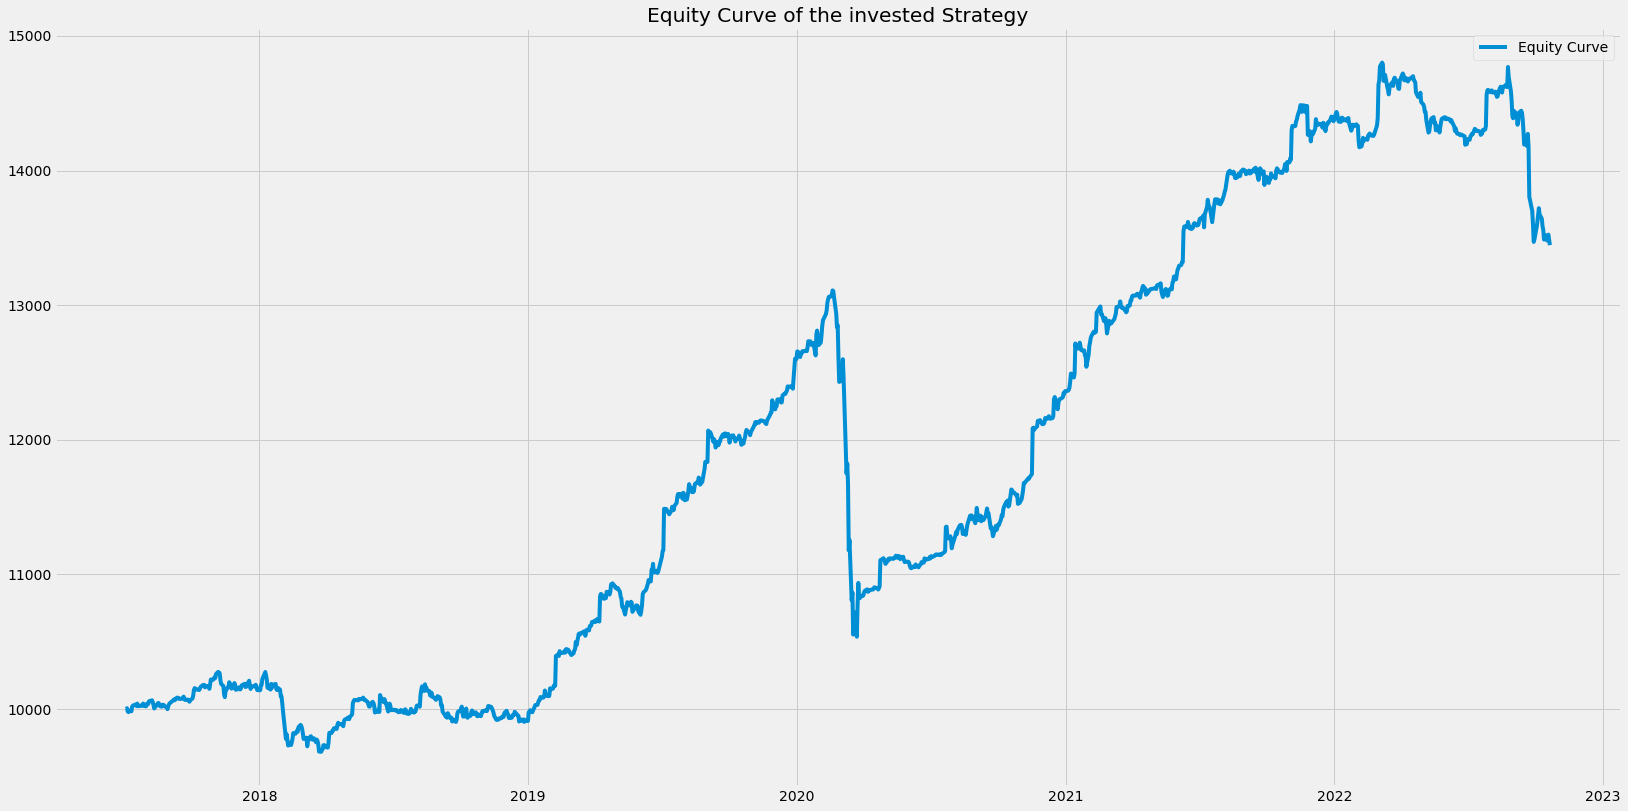

In [525]:
plt.figure(figsize = (25,13))
plt.plot(equity_list,label = "Equity Curve")
plt.legend()
plt.title("Equity Curve of the invested Strategy")

# Plotting the Drawdown : 


Text(0.5, 1.0, 'Drawdown of the Strategy')

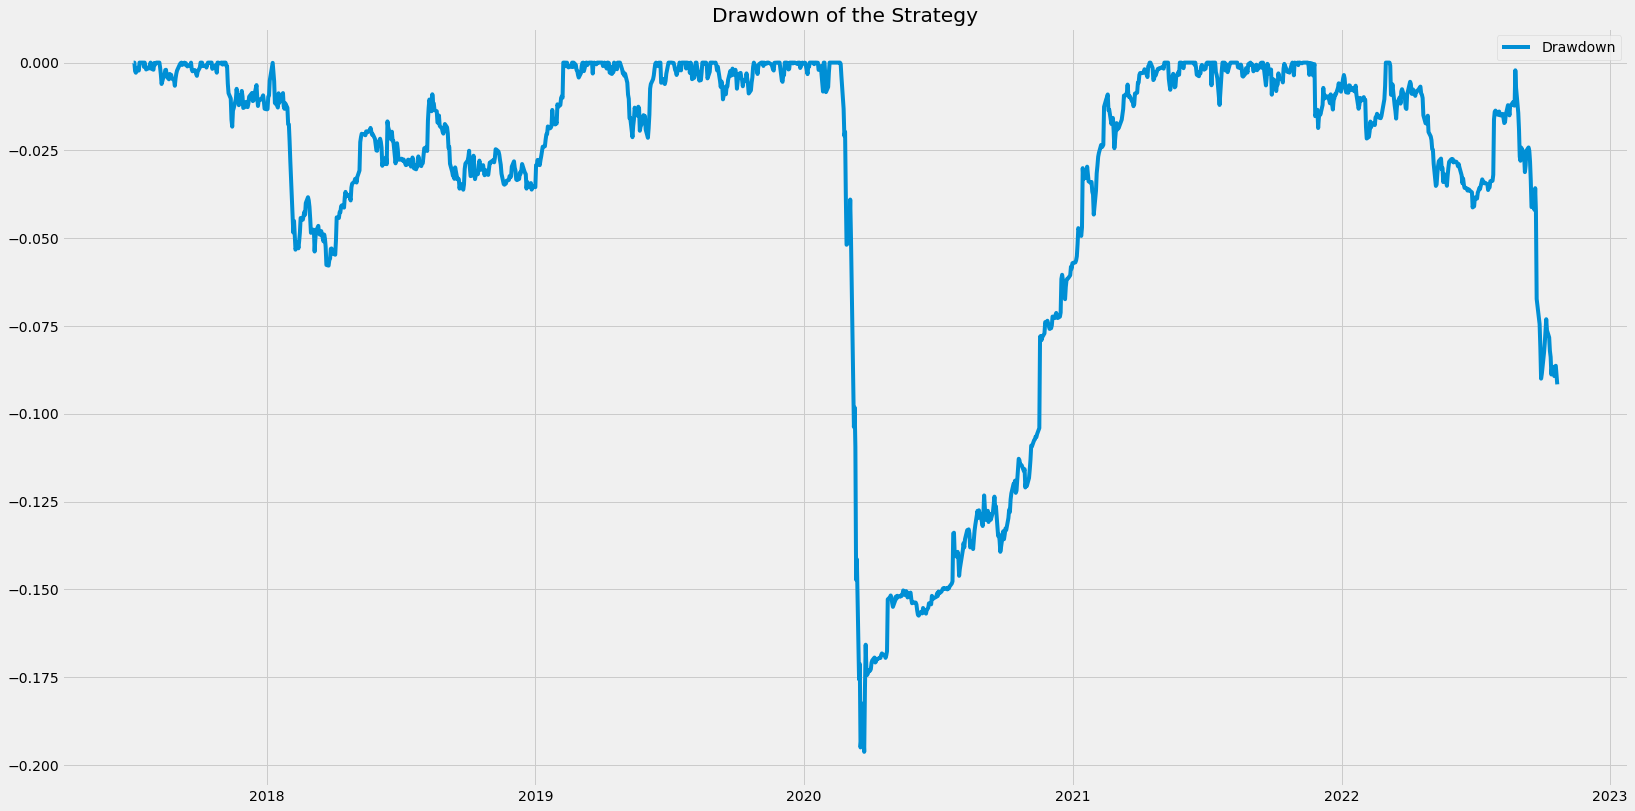

In [526]:
previous_peaks = equity_list.cummax()
drawdown = DD(equity_list)
plt.figure(figsize = (25,13))
plt.plot(drawdown,label = "Drawdown")
plt.legend()
plt.title('Drawdown of the Strategy')

# Plotting the investment weights :  

Text(0.5, 1.0, 'Allocation weights of the Strategy 93 21')

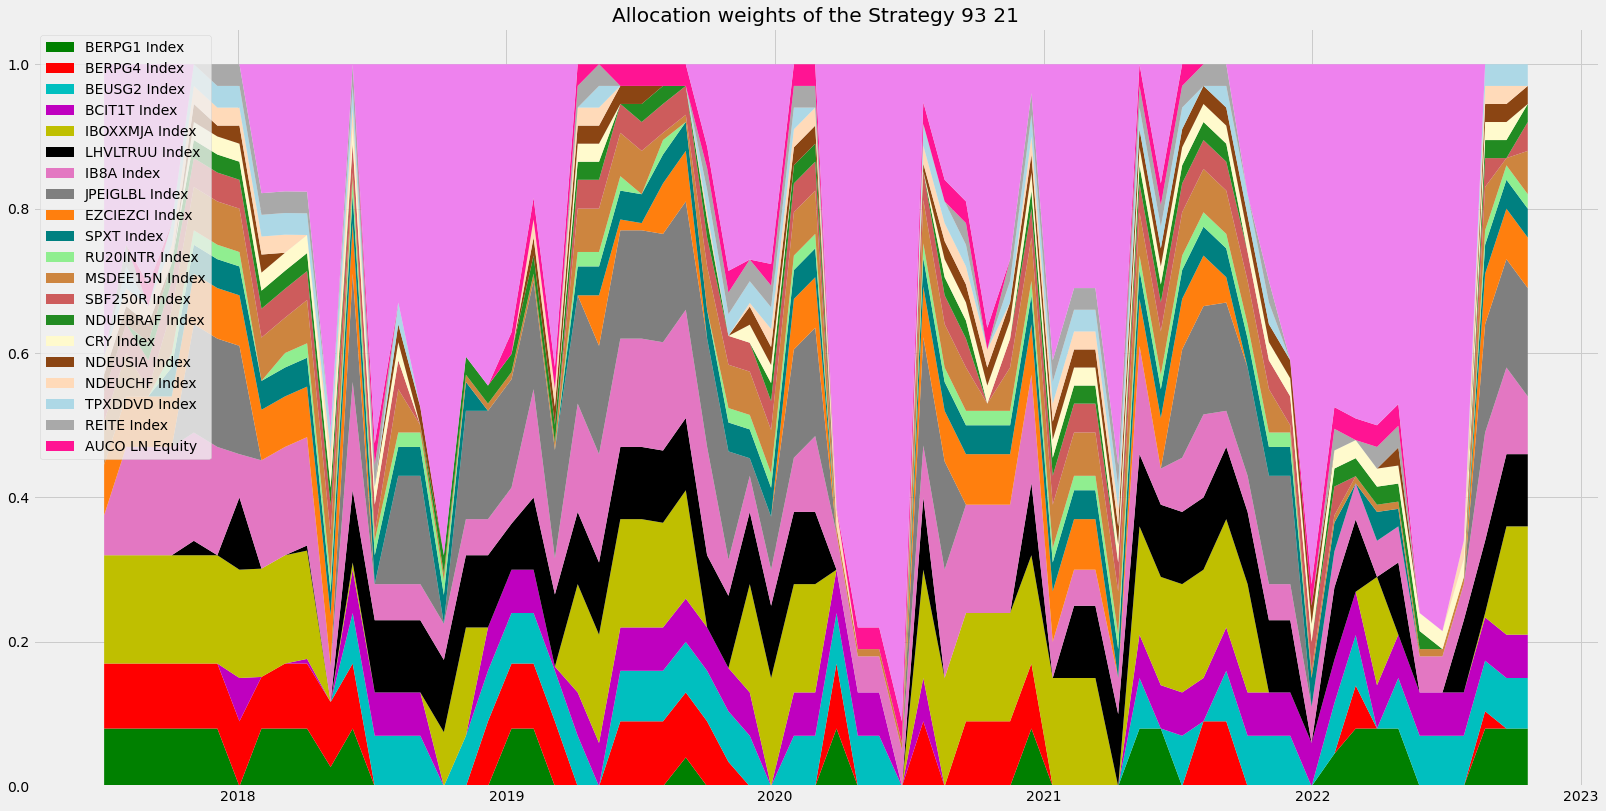

In [527]:
plt.figure(figsize = (25,13))
plt.stackplot(Weight_matrice.index,[Weight_matrice[Weight_matrice.columns[i]] for i in range(1, len(Weight_matrice.columns))],Weight_matrice[Weight_matrice.columns[0]],labels = Weight_matrice.columns[1:],colors = color_liste[-len(Weight_matrice.columns):])
plt.legend(loc=2)
plt.title("Allocation weights of the Strategy" + " " + '{}'.format(window_backtest) + " "  + '{}'.format(window_lenght))

# Now the return of each invested weights thorw the various investement window :

Text(0.5, 1.0, 'Realized returns of each invested Index 93 21')

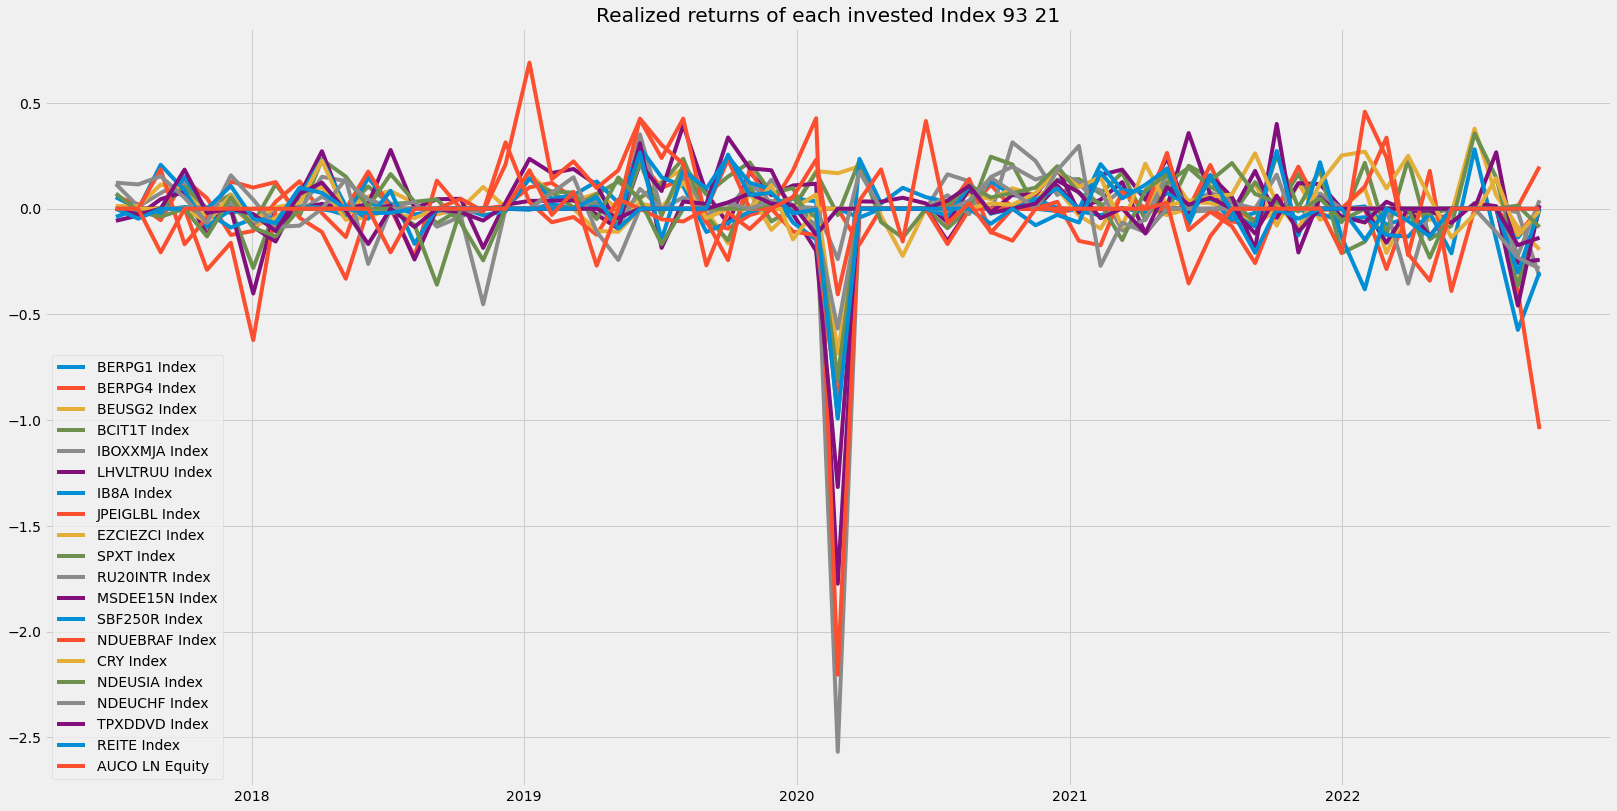

In [528]:
plt.figure(figsize = (25,13))
plt.plot(realized_returns,label = realized_returns.columns)
plt.legend(loc = 0)
plt.title('Realized returns of each invested Index ' '{}'.format(window_backtest) + " "  + '{}'.format(window_lenght))

# Lets now make a Statistics table : 

In [529]:
total_return = (equity_list.iloc[-1]/equity_list.iloc[0] - 1) * 100
duration  = get_yearly_duration(backtest_starting_date,backtest_ending_date,window_backtest)
Annualized_return = Get_Annualized_Return(total_return,duration)
MaX_DD = np.abs(Max_DD(equity_list)[0])
Calmar_Ratio = total_return[0]/MaX_DD
Mean_Annualized_vol = get_realized_ret_vol_sr(Weight_matrice,Output[3])[1].mean()
Mean_Annualized_return = get_realized_ret_vol_sr(Weight_matrice,Output[3])[0].mean()
Sharpe_ratio = Annualized_return[0]/Mean_Annualized_vol
Annualized_time_to_recovery = get_time_to_recovery(drawdown)[0]
stats_liste = [total_return[0] ,MaX_DD,Calmar_Ratio,Sharpe_ratio,Annualized_time_to_recovery]

Statistique_list = []
for value in stats_liste:
    Statistique_list.append(round(value,3))

Statistique_list = pd.DataFrame(Statistique_list).T
Statistique_list.columns = ["Total_return : Start to Date %","Max Drawdown %","Calmar Ratio","Sharp Ratio","Annualized time to recovery"]
Stats_list = ["Strategy statistics"]
Statistique_list.index = Stats_list

In [530]:
np.round(Statistique_list.T,3)

,Strategy statistics
Total_return : Start to Date %,34.458
Max Drawdown %,20.000
Calmar Ratio,1.723
Sharp Ratio,0.997
Annualized time to recovery,1.000
